In [1]:
# last inn pakker
from matplotlib import pyplot as plt
import json
import pandas as pd
import requests
from pyjstat import pyjstat
import seaborn as sb
import numpy as np 
import sympy as sp
# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/12937/"

# spørring fra SSB

apiQuery ={
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:Landet",
        "values": []
      }
    },
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrNaring",
        "values": [
          "47"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Oms"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


total, total_id, totalds = apiToDataframe(postUrl, apiQuery)

In [2]:
#laster inn flere kategorier av samme datasett
apiQuery ={
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:Landet",
        "values": []
      }
    },
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrHovedGr",
        "values": [
          "47.1",
          "47.2",
          "47.3",
          "47.4",
          "47.5",
          "47.6",
          "47.7",
          "47.8",
          "47.9"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Oms"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

spec, spec_id, specds = apiToDataframe(postUrl, apiQuery)

In [3]:
#setter sammen datasettene til et hoved datsett
df = pd.concat([spec,total])

In [4]:
#laster in kpi data

postUrl = "https://data.ssb.no/api/v0/no/table/03014/"



apiQuery ={
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": [
          "TOTAL"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiAar"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2017",
          "2018",
          "2019",
          "2020",
          "2021",
          "2022",
          "2023"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


kpi, kpi_id, kpids = apiToDataframe(postUrl, apiQuery)

#lager en dict som jeg kan lime inn i hoved datasettet

kpi_dict = kpi.set_index('år')['value'].to_dict()

#limer listen in i hoved datasettet
df["kpi"] = df["år"].map(kpi_dict)


In [5]:
#justerer for prisendring ved hjelp av kpi
df["value"] = round(df["value"]/df["kpi"]*100,1)

In [6]:
#endrer navn på næringen så de blir lettere å jobbe med
df = df.rename(columns = {"næring (SN2007)":"næring" })
df["næring"] = df["næring"].replace({"Butikkhandel med bredt vareutvalg": "bredt utvalg", 
                      "Detaljhandel med drivstoff til motorvogner":"drivstoff",
                      "Butikkhandel med IKT-utstyr i spesialforretninger":"ikt-utstyr",
                      "Butikkhandel med bøker, musikkartikler og andre fritidsartikler i spesialforretninger":"fritids",
                      "Detaljhandel utenom utsalgssted": "uten utsalgsted",
                      "Detaljhandel, unntatt med motorvogner":"total",
                      "Annen butikkhandel i spesialforretninger":"Annen",
                      "Butikkhandel med nærings- og nytelsesmidler i spesialforretninger":"Nytelsesmiddel",
                      "Butikkhandel med andre husholdningsvarer i spesialforretninger":"husholdningsvarer",
                      })

df["statistikkvariabel"] = df["statistikkvariabel"].replace({"Omsetning (mill. kr)":"omsetning",
                                                             "Lønn (mill. kr)":"lønn"})

In [7]:
#lager et midlertidig datasett for å finne prosent endring
temp = df
temp1 = temp[temp["år"] == "2017"]
temp_dict = temp1.set_index('næring')['value'].to_dict()
temp["ogval"] = temp["næring"].map(temp_dict)
temp["prcchange"] = (temp["value"]/temp["ogval"])*100-100

#limer prosent endring in i datasettet
df["prcchange"] = temp["prcchange"]

<h3>Oppgave 1</h3>

(i)

Detaljhandel er et begrep som beskriver salg av varer som går direkte til forbruker eller forbrukerens husholdning.
Altså hvis jeg går og kjøper meg sko på en skobutikk inngår dette under detaljhandel, mens når skobutikken kjøper sko fra produsenten telles det ikke innenfor detaljhandel.

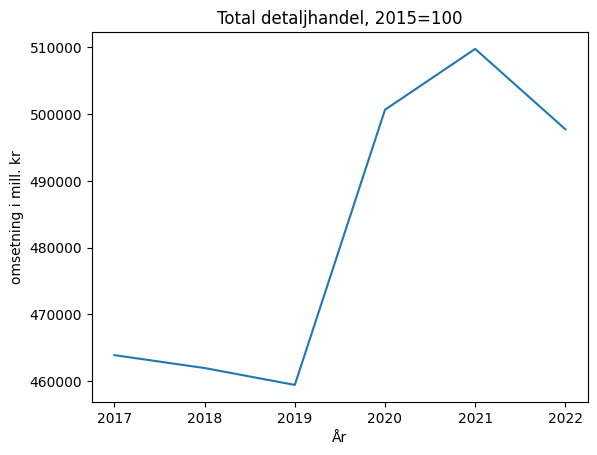

In [8]:
#lager et filtrert datasett for plotting
dfplot = df[df["næring"].isin(["total"])]
ax =sb.lineplot(data=dfplot,
           x= "år",  
           y="value",
           hue= "næring",
           legend = False)
ax.set(xlabel= "År",ylabel="omsetning i mill. kr",
      title = "Total detaljhandel, 2015=100")
plt.show()

(ii)

Figuren ovenfor viser omsetningen til all detaljhandel fra 2017 til 2022, det vi først ser er et stort hopp fra 2019 til 2020. Når vi tenker på store hendelser som kan forklare dette er covid 19 pandemien en stor kandidat. dette blir mer sannsynlig når vi ser at handelen gikk ned fra 2021 til 2022, perioden hvor restriksjonene rundt pandemien slapp mer og mer opp.

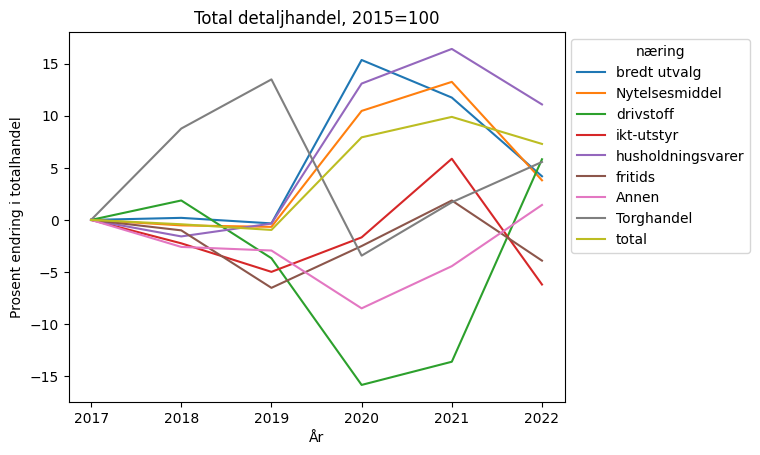

In [9]:
#
dfplot = df[-df["næring"].isin(["uten utsalgsted"])]
ax =sb.lineplot(data=dfplot,
           x= "år",  
           y="prcchange",
           hue= "næring",
           legend = "brief" )
ax.set(xlabel= "År",ylabel="Prosent endring i totalhandel",
      title = "Total detaljhandel, 2015=100")
sb.move_legend(ax,"upper left",bbox_to_anchor=(1, 1))
plt.show()

Denne figuren viser hvordan omsetning utviklet seg for flere forskjellige varer. Vi ser igjen en stor endring fra 2019 til 2022, men i dette tilfellet ser vi at den drastiske endringen er forskjellig for alle varene, I tillegg ser vi noen varer som er relativt upåvirket. den detaljerte endringen for alle varer skal vi se på senere. For å kunne illustrere alle varene sammen figur bruker jeg prosentvis endring, dette gjør at selv om for eksempel torghandel omsetter små verdier i sammenligning med for eksempel drivstoff kan de sammenlignes.

In [10]:
#iii)


# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/07312/"

# spørring fra SSB

apiQuery ={
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007vroms4",
        "values": [
          "47.22",
          "47.25",
          "47.26",
          "47.30",
          "47.91"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2017T1",
          "2017T2",
          "2017T3",
          "2017T4",
          "2017T5",
          "2017T6",
          "2018T1",
          "2018T2",
          "2018T3",
          "2018T4",
          "2018T5",
          "2018T6",
          "2019T1",
          "2019T2",
          "2019T3",
          "2019T4",
          "2019T5",
          "2019T6",
          "2020T1",
          "2020T2",
          "2020T3",
          "2020T4",
          "2020T5",
          "2020T6",
          "2021T1",
          "2021T2",
          "2021T3",
          "2021T4",
          "2021T5",
          "2021T6",
          "2022T1",
          "2022T2",
          "2022T3",
          "2022T4",
          "2022T5",
          "2022T6",
          "2023T1",
          "2023T2",
          "2023T3",
          "2023T4",
          "2023T5",
          "2023T6"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

dfdiv, dfdiv_id, dfdivds = apiToDataframe(postUrl, apiQuery)

In [11]:
#lager en års kolonne så vi kan lime inn kpi kolonnen 
dfdiv["år"] = dfdiv["termin"].str[:-2]
dfdiv["kpi"] = dfdiv["år"].map(kpi_dict)


In [12]:
#justerer verdien med hjelp av kpi
dfdiv["value"] = round(dfdiv["value"]/dfdiv["kpi"]*100,1)
#sletter års kollonnen for å holde datasetter oversiktlig
del dfdiv["år"]

In [13]:
#endrer navn på næring og kolonne
dfdiv = dfdiv.rename(columns = {"næring (SN2007)":"næring" })
dfdiv["næring"] = dfdiv["næring"].replace({"Butikkhandel med kjøtt og kjøttvarer":"kjøttvarer",
                                           "Butikkhandel med drikkevarer":"drikkevarer",
                                           "Butikkhandel med tobakksvarer":"tobakksvarer",
                                           "Detaljhandel med drivstoff til motorvogner":"drivstoff",
                                           "Postordrehandel og handel via internett":"netthandel"})

In [14]:
div_år = dfdiv[dfdiv['termin'].str.endswith('T5')]

In [15]:
div_år = dfdiv.copy(deep=True)
div_år["år"] = dfdiv["termin"].str[:-2]
div_år = div_år.groupby(["næring","år"]).sum()
div_år = div_år.reset_index()
del div_år["statistikkvariabel"]
del div_år["termin"]
del div_år["kpi"]

In [16]:
df_net = dfdiv[dfdiv["næring"].isin(["netthandel"])]
df_net["år"] = df_net["termin"].str[:-2]
del df_net["termin"]

C:\Users\Erik\AppData\Local\Temp\ipykernel_7076\1669288600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_net["år"] = df_net["termin"].str[:-2]


In [17]:
net_år = df_net.groupby(df_net["år"],).sum()
net_år = net_år.drop(net_år.tail(1).index)
#net_år.insert(4,"år",[2017,2018,2019,2020,2021,2022])
net_år = net_år.reset_index()
net_år = net_år.rename(columns = {"value":"net" })

In [18]:
net_år = net_år.reset_index()

In [19]:
total_net = pd.concat([total,net_år["net"]],axis=1,join = "outer").reset_index()

In [20]:
total_net["nett%"] = total_net["net"]/total_net["value"]*100

In [21]:
div_år["pct"] = div_år["value"].pct_change()*100

In [22]:
div_år.loc[div_år.år == "2017",["pct"]] = 0


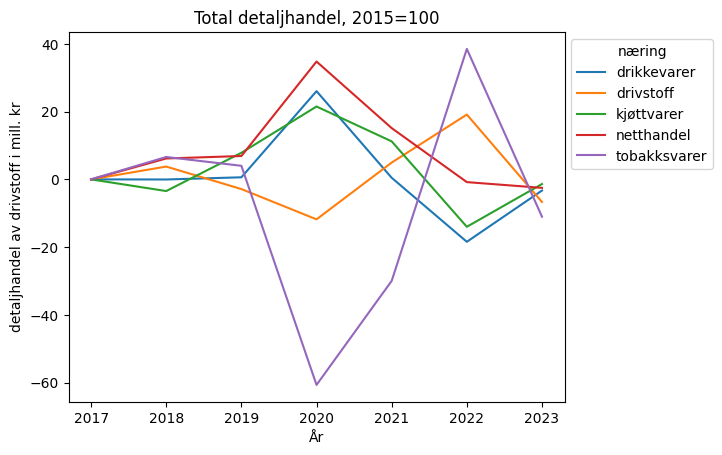

In [23]:

ax =sb.lineplot(data=div_år,
           x= "år",  
           y="pct",
           hue= "næring",
           legend = "brief" )
ax.set(xlabel= "År",ylabel="detaljhandel av drivstoff i mill. kr",
      title = "Total detaljhandel, 2015=100")
sb.move_legend(ax,"upper left",bbox_to_anchor=(1, 1))
plt.show()

(iiia)


Ovenfor ser vi utviklingen til den prosentvise utviklingen til detaljhandler av flere forskjellig vare fra år til år. Vi ser relativt lite endring fram til endringen fra 2019 til 2022 hvor vi ser en drastisk endring. Dette kan vi trygt si stammer hovedsakelig fra covid-19 pandemien som kom i 2022. Den hadde klart en stor effekt på samfunnets handlingsvaner med en unik effekt fra vare til vare. vi kan først å fremst se at tobakkskjøp gikk drastisk ned under denne tiden i lag med drivstoff. Drivstoff har en relativt åpenbar forklaring ved at folk flest holdte seg hjemme og dermed kjørte mindre. Mindre tobakkskjøp er også interessant, men har mindre åpenbare grunner, en tenkelig grunn kan være at folk er mindre i sammenhenger hvor det kan blir mye tobakksbruk men det kan være alternative grunner. Denne perioden viser også en økning i kjøttvarer, drikkevarer og til slutt nett handel. Nett handel har igjen en relativt åpenbar grunn i at folk fleste holdte seg hjemme uten muligheter til å gå i butikker, Netthandel fylte dette tomrommet. Drikkevarer og kjøttvarer er litt mindre åpenbart, en mulig faktor kan være at når folk ikke har mulighet til å gå til utesteder må de lage mer mat hjemme. Vi ser etter pandemien at ting begynner å stabilisere seg igjen, vi får tilbakeslag i de fleste varer fra 2020 til 2022 hvor de finner seg tilbake rundt normalen fra før pandemien.


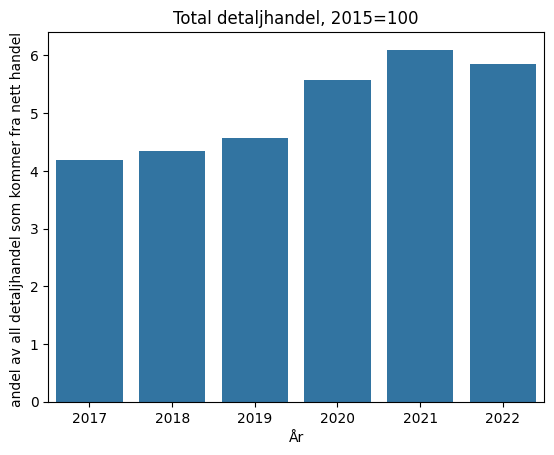

In [24]:
ax =sb.barplot(data=total_net,
           x= "år",  
           y="nett%",
           legend = "brief" )
ax.set(xlabel= "År",ylabel="andel av all detaljhandel som kommer fra nett handel ",
      title = "Total detaljhandel, 2015=100")
#sb.move_legend(ax,"upper left",bbox_to_anchor=(1, 1))
plt.show()

(iiib)

For å undersøke hvordan netthandel utviklet seg i forhold til andre varer har jeg overfor laget en figur som viser hvor stor andel av all detaljhandel som kommer fra netthandel. Før pandemien i 2020 ser vi en stødig økning fra rundt 4% til 4,5%, dette gir mening med tanke på hvordan internettet blir en større og større del av livene våre. I 2020 ser vi et raskt hopp fra rundt 4,5% til 5,5%, en stor faktor i det hoppe er nok at pandemien holdt folk hjemme og dermed borte fra fysiske butikker. Vi ser igjen en økning til 2021 men deretter andelen synke i 2022, dette kan bli forklart av at pandemien tok mer og mer slutt.

<h3>Oppgave 2</h3>

In [25]:



postUrl = "https://data.ssb.no/api/v0/no/table/12910/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrNaringUndGr",
        "values": [
          "47.111",
          "47.112",
          "47.190",
          "47.210",
          "47.220",
          "47.230",
          "47.241",
          "47.242",
          "47.251",
          "47.259",
          "47.260",
          "47.291",
          "47.292",
          "47.299",
          "47.300",
          "47.410",
          "47.420",
          "47.430",
          "47.510",
          "47.521",
          "47.522",
          "47.523",
          "47.524",
          "47.529",
          "47.531",
          "47.532",
          "47.533",
          "47.540",
          "47.591",
          "47.592",
          "47.593",
          "47.594",
          "47.599",
          "47.610",
          "47.620",
          "47.630",
          "47.641",
          "47.642",
          "47.650",
          "47.710",
          "47.721",
          "47.722",
          "47.730",
          "47.740",
          "47.750",
          "47.761",
          "47.762",
          "47.771",
          "47.772",
          "47.781",
          "47.782",
          "47.789",
          "47.791",
          "47.792",
          "47.799",
          "47.810",
          "47.820",
          "47.890",
          "47.911",
          "47.912",
          "47.913",
          "47.914",
          "47.915",
          "47.916",
          "47.917",
          "47.919",
          "47.990"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Produksjonsverdi",
          "Lonnskost",
          "BruttoInvesteringer"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2022"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


In [26]:
temp, df2_id, ds2 = apiToDataframe(postUrl, apiQuery)


In [27]:
from sklearn.linear_model import LinearRegression

# slå sammen verdier for foretak og bedrift

df_sum = temp.groupby(['næring (SN2007)', 'statistikkvariabel']).sum().reset_index()

# dropp kolonner

df_sum = df_sum.drop(columns=['foretak/bedrift', 'år'])

# pivot

df_pivot = df_sum.pivot_table(index='næring (SN2007)', columns='statistikkvariabel', values='value')

# lag en kopi av datasettet

data = df_pivot.copy()

# fjern rader med verdier lik 0

df2 = data.drop(data[data.eq(0).any(axis=1)].index)


In [28]:
#i)
df2["logK"] = np.log(df2["Bruttoinvesteringer (mill. kr)"])
df2["logN"] = np.log(df2["Lønnskostnader (mill. kr)"])
df2["logx"] = np.log(df2["Produksjonsverdi (mill. kr)"])


In [29]:
logx = df2["logx"]
logKN = df2[["logN","logK"]]

In [30]:
reg = LinearRegression(positive = True).fit(logKN,logx)

In [31]:
a_coef = reg.coef_[0]
b_coef = reg.coef_[1]

In [32]:
Z_num = np.exp(reg.intercept_)


In [33]:
print(a_coef,b_coef,Z_num)

0.8087532932532777 0.15125109895927744 4.872718672079993


i)

Vi starter med produksjonsfunksjonen
\begin{equation}
   x = ZN^aK^{b}\;\;(1)
\end{equation}
for å finne a,b og Z trenge vi linær regression dermed transformere vi funksjonen slik at å bruke linær regresjon blir mulig
\begin{equation}
   log(x) = log(Z)+alog(N)+blog(K)\;\;(1)
\end{equation}
derretter bruker jeg linær regresjon til å estimere coefficiene a og b, og z


Z er en omtolkning fra enhtene som kommer in i funksjonen til enhetene som kommer ut i fra funksjonen. De tar input formen arbeidskraft og kapital og gir ut et svar i hvor man enheter produsert.
a og b er hvordan produktiviteten er fordelt mellom kapital og arbeidskraft, altså hvis a er lik 0.7 og b er lik 0.3 vil dette si at 30% av produktiviteten av inputtet kommer fra kapital og 70% fra arbeidskraft. 

I dette datasett er a≈0.8, b≈0.15 og Z≈4.87

In [34]:
num = np.linspace(1,100,100)
num1 = np.linspace(5,200,200)

(ii)

Skalautbytte av en cobb douglass funksjon kan man finne med å plusses sammen a og b, som jeg nevnte tidligere er a og b hvor mye av produktiviteten som kommer fra arbeidskraft og kapital. Hvis mengden produktivitet fra kapital og arbeid er over 1 har man økende skalautbytte , dermed hvis man øker inverdien(kapital og arbeidskraft) får du mer utverdier per inverdier. For eksempel hvis du har skalutbytte på 1.05 å du putter in 100% mer inverdier får du ut 105% mer utverdier. Hvis skalautbytte er lik 1 hvil forholde mellom inverdi å utverdi være likt, altså 100% in 100% ut å dette kalles konstant skalautbytte. Til slutt hvis vi man har skalautbytte mindre en 1 har man avtakende skalautbytte, f.eks hvis du har 0.8 skalautbytte å du putter 100% in får du bare 80% ut.

Når vi plusser sammen a og b i dette tilfellet får vi en verdi på 0.96, dette vil si at funksjonen har avtakende skalautbytte

(iii)



En av grunnene til at næringen har jevnt over avtakende skalautbytte kan komme av at mange av næringene er avhengig av reklame, dette vil være mye av netthandel. Ta for eksempel for oss internett handel med helsekost, la oss si man har en bedrift som selger helse kost på nett uten noen fysiske butikker. En stor hindring for hvor mye man kan selge er at folk ikke vet at butikken din eksisterer, dermed må man reklamere. Når man reklamerer så får man mest nytte av reklamen første gang den potensielle kunden ser den. Dermed er det bare så mye man kan reklamere før alle potensielle kunder har sett reklamen. La oss si du sender en bølge reklame ut å 100 personer ser den, etter de sender du ut en bølge til å 100 personer ser den igjen, sjansen er stor for at noen av de som så reklamen i bølge en ser den igjen i bølge to og dermed har bølge 2 mindre effekt. Dermed får man mindre produktivitet for hver reklamebølge, noe som vil gi et negativ skalautbytteE
en annen mulighet det er at en andel av det man produserer blir ikke solgt av en del grunneF. for eksempel hvis du har 10 kunder å en vare er det store sjanse for at varen blir solgt, hvis du har 20 varer og 10 kunder er det en stor sjanse at noen av varene ikke blir solg
(

iiii)
Denne analysen er spredt over mange bedrifter og varer, dette kan gjøre den unøyaktig og irrelevant for en del bedrifter. something somethingt. 


In [35]:
avg_K = df2["Bruttoinvesteringer (mill. kr)"].mean()
avg_K = avg_K*1000000

In [36]:
def Cv(y,w):
    L = (y/(Z_num*(avg_K**0.15)))**(1/0.8)
    output = L*w
    return output

In [37]:
Cv(1,144)

0.5216561795529562

In [38]:
def Cf(f):
    output = f**b_coef
    return output

Cf(avg_K)


18.860890699106225

In [39]:
def C(f,y,w):
    v = Cv(y,w)
    k = Cf(f)
    output = v+k
    return output

C(avg_K,100,144)

183.82305898801604

<h3>Oppgave 3</h3>

(i)

Variable kostnads funksjonen er $L=w*(\frac{Y}{ZK^b})^{\frac{1}{a}}$, totale kostnader vill være variable kostnader pluss faste kostnader. Siden faste kostnader bare vil si mengde kapital vil det være likt $K^b$, dette inkluderer ikke mulighetskostnaden. Vi kan nå sette sammen variabel kostnad med fast kostnad og komme fram til $C=w*(\frac{Y}{ZK^b})^{\frac{1}{a}}+K^b$ som total kostnadsformel



(ii)

Grensekostnad vil ha denne formelen $MC=w*(\frac{1}{a}(\frac{Y}{ZK^b})^{\frac{1}{a}-1})(\frac{1}{ZK^b})$  Dette kommer vi fram til med å vite at siden grensekostnaden er lik kostnaden for å produsere 1 til vil formelen for dette være formelen for totale kostnader derivert.

Gjennomsnittskostnad er hvor mye det koster per produkt produsert, dermed tar vi totale kostnader og deler på antall produsert. Når vi skriver dette som en formel får vi  $\frac{w*(\frac{Y}{ZK^b})^{\frac{1}{a}}+K^b}{y}$

In [40]:
def MC(y):
    output = 144*(1/a_coef)*(y/(Z_num*avg_K**b_coef))**((1/a_coef)-1)*(1/(Z_num*avg_K**b_coef))
    return output
MC(5)


def AC(y):
    output=  ((144*(y/(Z_num*avg_K**b_coef))**(1/a_coef)+avg_K**b_coef)/y)
    return output





w,a,b,Z,K,y=sp.symbols('w a b Z K y', real=True, positive=True)

MC_sp = sp.lambdify((w,a,b,Z,K,y), sp.diff(w*(y/(Z*K**b))**(1/a)+K**b,y))

display(MC_sp(144,a_coef,b_coef,Z_num,avg_K,y))



0.665183446011354*y**0.236471008331127

In [41]:
temp = np.linspace(1,100,1000)
list = np.isclose(AC(temp),MC(temp),atol=0.0001)

res = [i for i, val in enumerate(list) if val]
res
kryss = temp[565]

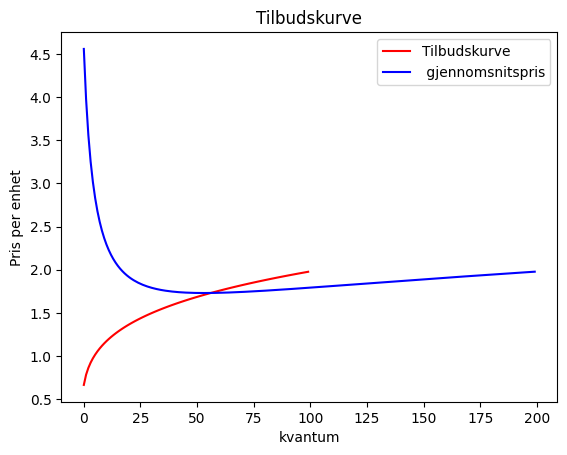

In [42]:

plt.plot(MC(num),color = "red")
plt.plot(AC(num1),color = "blue")
plt.title("Tilbudskurve")
plt.xlabel("kvantum")
plt.ylabel("Pris per enhet")
plt.legend(["Tilbudskurve"," gjennomsnitspris"])

(iii)

Tilbudskurven beskriver hvor mye det vil koste å dermed hvor høy pris bedriften må ta får vært antall enheter produsert. Dette vil i praksis si at tilbudskurven på kort tid er lik grensekostnaden til bedriften. Figuren ovenfor viser grensekostnaden i rødt, som vi kan se starter ganske lavt og øker raskt for de første enhetene produsert, kurven slakker deretter av kraftig og blir mer og mer horisontal. Vi ser også i grafen for gjennomsnittskostnad, dette viser hvor mye det kostet per enhet å produsere vært antall enheter. denne grafen i motsetning til tilbudsgrafen inkluderer faste kostnader, noe som fører til at gjennomsnitts kostnaden for få antall enheter er veldig høy. Tilbudsgrafen er dermed lavere en gjennomsnittskostnads grafen for de første enhetene, noe som er problematisk for bedriften. Når gjennomsnittskostnaden er høyere en tilbudsgrafen vil salgsprisen være lavere en kostnaden. Dette vil da si at for all produksjon hvor tilbudsfunksjon er under gjennomsnittskostnaden vil bedriften tape penger noe som gjør denne delene av tilbudsfunksjonen irrelevant. For å få en relevant tilbudsfunksjon kutter vi alle verdiene under gjennomsnittskostnaden og få alle relevante tibudsverdier. dette viser jeg i figuren under.

(10.0, 200.0)

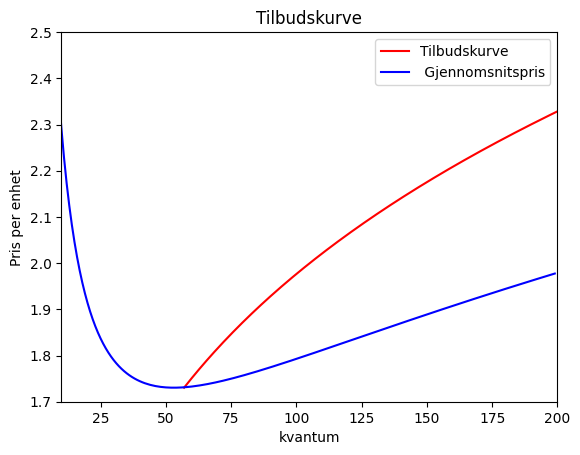

In [43]:
plt_num = np.linspace(kryss,200,200)
plt.plot(plt_num,MC(plt_num),color = "red")
plt.plot(AC(num1),color = "blue")
plt.title("Tilbudskurve")
plt.xlabel("kvantum")
plt.ylabel("Pris per enhet")
plt.legend(["Tilbudskurve"," Gjennomsnitspris"])
plt.ylim(1.7,2.5)
plt.xlim(10,200)

Ger ser den aktuelle tilbudskurven etter at de irrelevante verdiene hvor tilbuds verdien er lavere en gjennomsnittskostnaden.

In [44]:
w,a,b,Z,K,y=sp.symbols('w a b Z K y', real=True, positive=True)

MC_sp = sp.lambdify((w,a,b,Z,K,y), sp.diff(w*(y/(Z*K**b))**(1/a)+K**b,y))

In [45]:


display(MC_sp(144,a_coef,b_coef,Z_num,avg_K,y))

0.665183446011354*y**0.236471008331127

In [46]:
MC_sp(144,a_coef,b_coef,Z_num,avg_K,1)

0.6651834460113538

iv)

en lønnsøkning på 5% vil gi en økning i tilbudskurven på 5% dette er fordi tilbudskurven kun tar i bruk variabel kostnad ikke faste kostnader, noe som er helt koblet opp mot lønn i dette eksemplet. du kan tenke på det som at vis lønn går opp med 5% vil alle timen jobbet koste 5% dermed vil de variable kostnadene gå opp med 5% og da er det naturlig at prisen må økes med 5%.